# Imports and path preparations

In [1]:
import pandas as pd
from math import sqrt
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
import sys
import os

# Get the absolute path to the 'src' directory
sys.path.append(os.path.abspath(".."))
print(os.path.abspath(".."))
project_root = os.path.abspath("..")
print(sys.path)
print(project_root)

/home/julia/school/bakalarka/hospital_sim
['/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages', '/home/julia/school/bakalarka/hospital_sim']
/home/julia/school/bakalarka/hospital_sim


In [3]:
from src.main import App
from data_generator import DataGenerator
from src.process_data import DataProcessor

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
exp_layout = project_root + "/input/experiments/layouts/expLayout.json"
two_nurses = project_root + "/input/experiments/people/expTwoNurses.json" #two nurses, 4 patients each, 2 patients per room
one_nurse = project_root + "/input/experiments/people/expOneNurse.json" #one nurse, 8 patients, 2 patients per room
exp_nurse_log = project_root + "/output/expNurseLog.csv"
exp_event_log = project_root + "/output/expEventLog.csv"
event_paths = ["expEvents1.json",
"expEvents2.json",
"expEvents3.json",
"expEvents4.json",
"expEvents5.json",
"expEvents6.json",
"expEvents7.json",
"expEvents8.json",]
full_event_paths = list(map(lambda x: project_root + "/input/experiments/events/" + x, event_paths))

In [6]:
# full_event_paths = list(map(lambda x: project_root + "/input/experiments/events/" + x, event_paths))
print(full_event_paths)


['/home/julia/school/bakalarka/hospital_sim/input/experiments/events/expEvents1.json', '/home/julia/school/bakalarka/hospital_sim/input/experiments/events/expEvents2.json', '/home/julia/school/bakalarka/hospital_sim/input/experiments/events/expEvents3.json', '/home/julia/school/bakalarka/hospital_sim/input/experiments/events/expEvents4.json', '/home/julia/school/bakalarka/hospital_sim/input/experiments/events/expEvents5.json', '/home/julia/school/bakalarka/hospital_sim/input/experiments/events/expEvents6.json', '/home/julia/school/bakalarka/hospital_sim/input/experiments/events/expEvents7.json', '/home/julia/school/bakalarka/hospital_sim/input/experiments/events/expEvents8.json']


In [5]:
params1 = {"event_path" : full_event_paths[0], "nurse_cnt": 2, "people_path": two_nurses, "request_assigner": "basic", "include_plans": True}
params2 = {"event_path" : full_event_paths[1], "nurse_cnt": 2, "people_path": two_nurses, "request_assigner": "other", "include_plans": True}
params3 = {"event_path" : full_event_paths[2], "nurse_cnt": 1, "people_path": one_nurse,  "request_assigner": "basic", "include_plans": True}
params4 = {"event_path" : full_event_paths[3], "nurse_cnt": 1, "people_path": one_nurse,  "request_assigner": "other", "include_plans": True}
params5 = {"event_path" : full_event_paths[4], "nurse_cnt": 2, "people_path": two_nurses, "request_assigner": "basic", "include_plans": False}
params6 = {"event_path" : full_event_paths[5], "nurse_cnt": 2, "people_path": two_nurses, "request_assigner": "other", "include_plans": False}
params7 = {"event_path" : full_event_paths[6], "nurse_cnt": 1, "people_path": one_nurse,  "request_assigner": "basic", "include_plans": False}
params8 = {"event_path" : full_event_paths[7], "nurse_cnt": 1, "people_path": one_nurse,  "request_assigner": "other", "include_plans": False}
params_lst = [params1, params2, params3, params4, params5, params6, params7, params8]

# Functions for experiment generation and running

In [6]:
def generate_exp(params):
    # exp_events = project_root + "/input/events/" + exp_event_path
    # if nurse_cnt == 1:
    #     people_file = one_nurse
    # elif nurse_cnt == 2:
    #     people_file = two_nurses
    event_gen = DataGenerator(rnd=42, layout_file=exp_layout, people_file=params["people_path"], out_file=params["event_path"], request_assigner=params["request_assigner"],
                               include_plans=params["include_plans"], min_requests=1, max_requests=5, max_req_len=120)
    event_gen.create_events() 

In [7]:
def run_exp(params):
    app = App(exp_layout, params["people_path"], params["event_path"], exp_nurse_log, exp_event_log)
    app.run_simulation()

In [8]:
def process_nurse_data(params):
    dp = DataProcessor(exp_nurse_log, exp_event_log, params["people_path"])
    all_results = []
    for i in range(params["nurse_cnt"]):
        nurse_results = {}
        nurse_results["nurse_dst_walked"] = dp.nurse_dst_walked(i)
        nurse_results["nurse_time_walked"] = dp.nurse_time_walked(i)
        nurse_results["nurse_time_at_own_patients"] = dp.nurse_time_at_own_patients(i)
        nurse_results["nurse_time_at_other_patients"] = dp.nurse_time_at_other_patients(i)
        nurse_results["nurse_time_resting"] = dp.nurse_time_resting(i)
        all_results.append(nurse_results)
    return all_results

In [9]:
def process_patient_data(params):
    dp = DataProcessor(exp_nurse_log, exp_event_log, params["people_path"])
    all_results = []
    for i in range(8):
        patient_results = []
        for lvl in range(4):
            if lvl == 0:
                lvl = None

            level_results = {}
            level_results["total_time_waiting"] = dp.patient_total_time_waiting(i, lvl)
            level_results["avg_time_waiting"] = dp.patient_avg_time_waiting(i, lvl) #could be changed to histogram somehow
            patient_results.append(level_results)
        all_results.append(patient_results)
    return all_results


# Running the actual experiments

In [ ]:
params1 = params_lst[0]
print(params1)

In [12]:
# generating each scenarion once
# %%capture
for params in params_lst:
    generate_exp(params)

{'time': 2867.554752696838, 'patient': 0, 'level': 2, 'duration': 100.17219002454924}
{'time': 2148.660568607353, 'patient': 0, 'level': 2, 'duration': 38.99774242362026}
{'time': 1653.2960110771219, 'patient': 0, 'level': 2, 'duration': 42.85801361297467}
{'time': 74.1041794648888, 'patient': 1, 'level': 3, 'duration': 104.91983767203796}
{'time': 764.4207984417942, 'patient': 1, 'level': 2, 'duration': 46.50640588680905}
{'time': 1095.2720746543357, 'patient': 1, 'level': 2, 'duration': 68.87505167779042}
{'time': 1889.188776930201, 'patient': 2, 'level': 2, 'duration': 34.199909689225386}
{'time': 1318.90263585729, 'patient': 3, 'level': 2, 'duration': 100.66583652537122}
{'time': 718.825615770095, 'patient': 3, 'level': 2, 'duration': 83.31731119758382}
{'time': 167.2214857919918, 'patient': 3, 'level': 2, 'duration': 45.347171131856236}
{'time': 234.18573474700625, 'patient': 3, 'level': 3, 'duration': 116.90688297671034}
{'time': 1387.499409143698, 'patient': 4, 'level': 2, 'dura

In [ ]:
# running each scenario once
%%capture
nurse_results = []
patient_results = []
done = []
for i, params in enumerate(params_lst):  
    run_exp(params)
    done.append(i)
    exp_results_nurse = process_nurse_data(params)
    nurse_results.append(exp_results_nurse)
    exp_results_patient = process_patient_data(params)
    patient_results.append(exp_results_patient)

In [14]:
%%capture
# generating and running each scenario n times
nurse_results = []
patient_results = []
done = []
for i, params in enumerate(params_lst):
    #data generator for that particular scenario:
    event_gen = DataGenerator(rnd=42, layout_file=exp_layout, people_file=params["people_path"], out_file=params["event_path"], 
                request_assigner=params["request_assigner"], include_plans=params["include_plans"], 
                min_requests=1, max_requests=5, max_req_len=120) 
    nurse_results_scenario = []
    patient_results_scenario = []
    for _ in range(10):
        event_gen.create_events() 
        run_exp(params)
        done.append(i)
        exp_results_nurse = process_nurse_data(params)
        nurse_results_scenario.append(exp_results_nurse)
        exp_results_patient = process_patient_data(params)
        patient_results_scenario.append(exp_results_patient)
    nurse_results.append(nurse_results_scenario)
    patient_results.append(patient_results_scenario)

## Test prints

In [ ]:
run_exp(params_lst[0])

In [ ]:
res = process_patient_data(params_lst[0])
for i, patient in enumerate(res):
    print(i)
    for lvl in patient:
        print(lvl)

In [ ]:
for res in nurse_results:
    print(res)

In [15]:
for i, exp in enumerate(patient_results):
    print("\n---------------- EXPERIMENT ", i, "---------------------------")
    for l, run in enumerate(exp):
        print("RUN", l)
        for j, patient in enumerate(run):
            print("\tpatient", j)
            for k, lvl in enumerate(patient):
                print("\t\tlevel", k, lvl)


---------------- EXPERIMENT  0 ---------------------------
RUN 0
	patient 0
		level 0 {'total_time_waiting': np.float64(346.48860497927194), 'avg_time_waiting': np.float64(69.29772099585439)}
		level 1 {'total_time_waiting': np.float64(140.0), 'avg_time_waiting': np.float64(70.0)}
		level 2 {'total_time_waiting': np.float64(206.48860497927194), 'avg_time_waiting': np.float64(68.82953499309065)}
		level 3 {'total_time_waiting': 0, 'avg_time_waiting': 0}
	patient 1
		level 0 {'total_time_waiting': np.float64(744.3014950080155), 'avg_time_waiting': np.float64(148.8602990016031)}
		level 1 {'total_time_waiting': np.float64(451.2780712454933), 'avg_time_waiting': np.float64(225.63903562274666)}
		level 2 {'total_time_waiting': np.float64(188.1035860904842), 'avg_time_waiting': np.float64(94.0517930452421)}
		level 3 {'total_time_waiting': np.float64(104.91983767203797), 'avg_time_waiting': np.float64(104.91983767203797)}
	patient 2
		level 0 {'total_time_waiting': np.float64(609.4891136937

In [16]:
for i, exp in enumerate(nurse_results):
    print("\n---------------- EXPERIMENT ", i, "---------------------------")
    for l, run in enumerate(exp):
        print("RUN", l)
        for j, nurse in enumerate(run):
            print("\tnurse", j)
            for k, stat in enumerate(nurse):
                print("\t\t", stat, nurse[stat])


---------------- EXPERIMENT  0 ---------------------------
RUN 0
	nurse 0
		 nurse_dst_walked 198.92131783625518
		 nurse_time_walked 198.92131783625564
		 nurse_time_at_own_patients 1262.766352818528
		 nurse_time_at_other_patients 0
		 nurse_time_resting 1526.039272066604
	nurse 1
		 nurse_dst_walked 268.5302749838945
		 nurse_time_walked 268.5302749838945
		 nurse_time_at_own_patients 1223.029345273675
		 nurse_time_at_other_patients 0
		 nurse_time_resting 1496.1673224638182
RUN 1
	nurse 0
		 nurse_dst_walked 220.0
		 nurse_time_walked 220.0
		 nurse_time_at_own_patients 1367.8352106783314
		 nurse_time_at_other_patients 0
		 nurse_time_resting 1924.9682873039737
	nurse 1
		 nurse_dst_walked 300.0
		 nurse_time_walked 300.0
		 nurse_time_at_own_patients 1055.1024177953052
		 nurse_time_at_other_patients 0
		 nurse_time_resting 2157.701080187
RUN 2
	nurse 0
		 nurse_dst_walked 222.0
		 nurse_time_walked 222.0
		 nurse_time_at_own_patients 1116.9189060495833
		 nurse_time_at_other_p

# Plot data

[np.float64(467.92009101924504), np.float64(433.74911214177484), np.float64(1103.9852866931567), np.float64(939.1147247421097), np.float64(472.8487257985231), np.float64(443.03117920083866), np.float64(1102.601247638579), np.float64(953.2418790964427)]
8


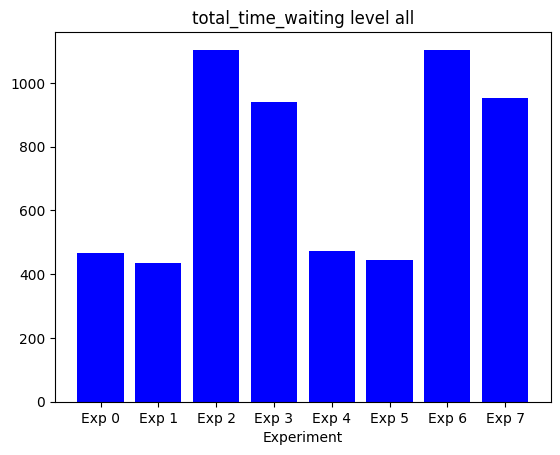

[np.float64(222.75245661610884), np.float64(159.887355386533), np.float64(738.9849880506537), np.float64(225.61725413956228), np.float64(227.60245661610884), np.float64(201.1938227164613), np.float64(740.1336471715247), np.float64(309.83574399405745)]
8


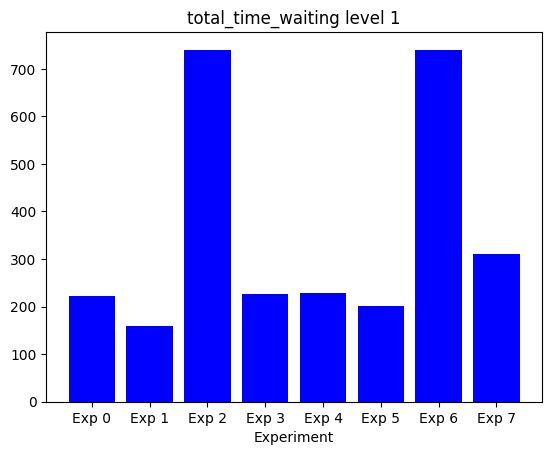

[np.float64(186.14670226157205), np.float64(219.98429236263746), np.float64(290.8572785187254), np.float64(622.3575609527841), np.float64(186.19907649870098), np.float64(188.16022597899624), np.float64(290.6538701756411), np.float64(552.0485938140775)]
8


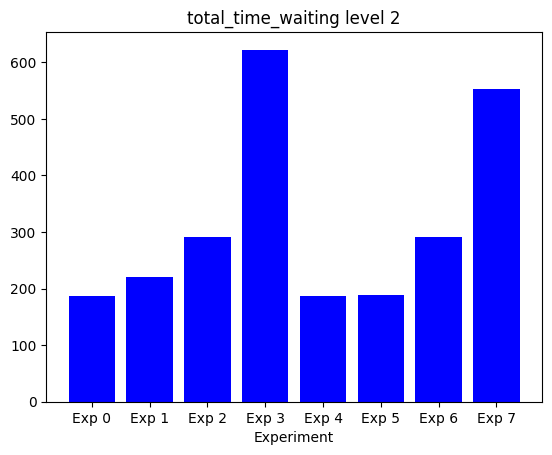

[np.float64(59.02093214156427), np.float64(53.87746439260438), np.float64(74.14302012377777), np.float64(91.13990964976372), np.float64(59.04719268371332), np.float64(53.67713050538125), np.float64(71.81373029141355), np.float64(91.35754128830845)]
8


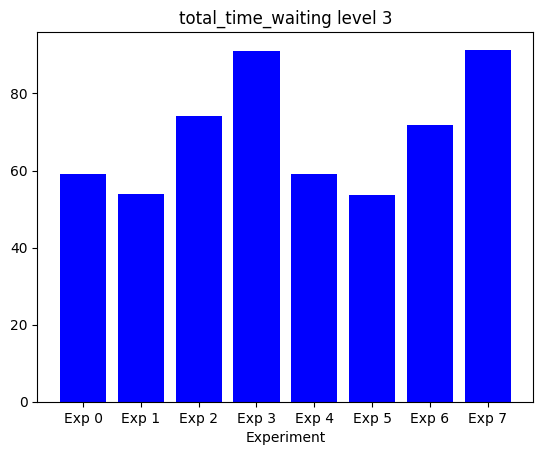

[np.float64(107.61845550304847), np.float64(99.35944019029994), np.float64(264.06280139084555), np.float64(210.93979957404068), np.float64(108.86772204051265), np.float64(102.56688836965569), np.float64(263.8308301114533), np.float64(216.65554062420196)]
8


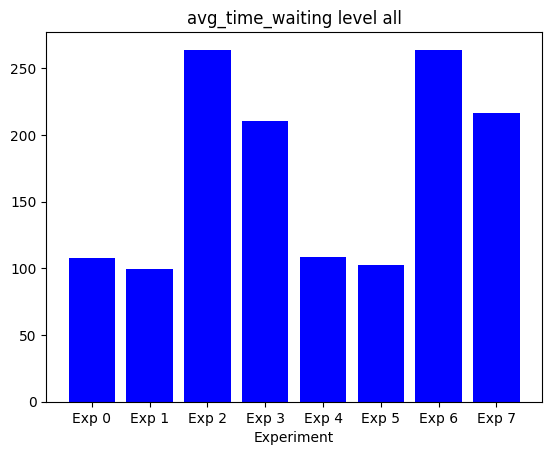

[np.float64(111.37622830805442), np.float64(79.9436776932665), np.float64(369.49249402532683), np.float64(112.80862706978114), np.float64(113.80122830805442), np.float64(100.59691135823066), np.float64(370.06682358576234), np.float64(154.91787199702873)]
8


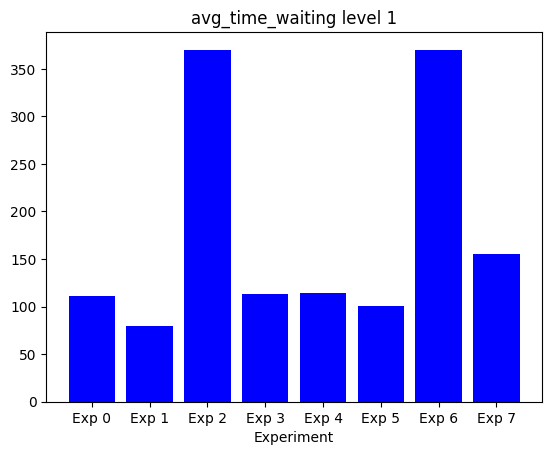

[np.float64(94.83856021445727), np.float64(117.46835017085246), np.float64(145.64441326098148), np.float64(326.49845532132923), np.float64(94.85601829350024), np.float64(99.28843393911188), np.float64(145.3368487190151), np.float64(293.4865060550707)]
8


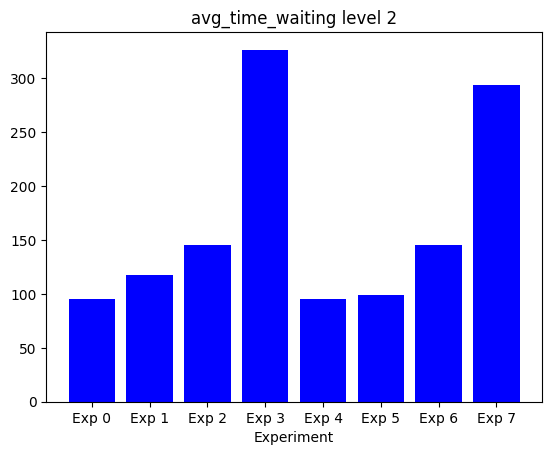

[np.float64(45.53485179066145), np.float64(41.5431920340782), np.float64(54.60971679341289), np.float64(68.67773597919754), np.float64(45.561112332810495), np.float64(41.33115536154117), np.float64(53.859182812273595), np.float64(68.88958128948863)]
8


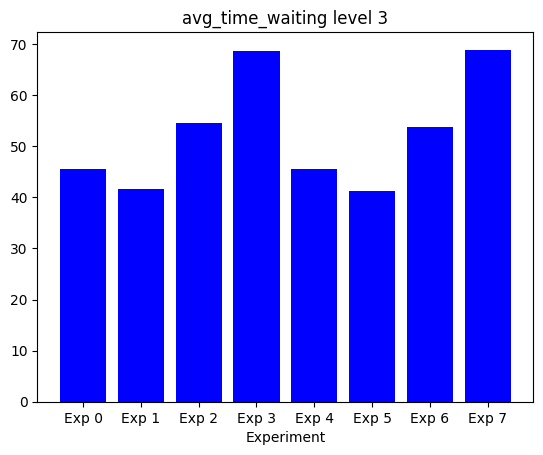

In [17]:
def plot_patient_stat(stat_name, level, avg_patient = False):
# by default, prints a cumulative value for all patients. If avg_patient is true, averages value out for one patient
    if level == 0:
        level_title = "all"
    else:
        level_title = level
    values = [0 for _ in range(len(patient_results))]

    for i, exp in enumerate(patient_results):
        for run in exp:
            for patient in run:
                # values.append(patient[level][stat_name])
                values[i] += patient[level][stat_name]

    runs = len(patient_results[0])
    values = list(map(lambda x: x / runs, values)) 
    if avg_patient:
        values = list(map(lambda x: x / 8, values)) 

    print(values)
    print(len(values))

    labels = ["Exp " + str(x) for x in range(8)]
    # colors = ['red' if i % 2 == 0 else 'blue' for i in range(len(values))]
    x = np.arange(len(values))
    plt.bar(x, values, color="blue")
    plt.xticks(ticks=x, labels=labels)

    plt.xlabel("Experiment")
    plt.ylabel("")
    plt.title(stat_name + " level " + str(level_title))

    # Show the chart
    plt.show()

for i in range(4):
    plot_patient_stat("total_time_waiting", i, avg_patient=True)

for i in range(4):
    plot_patient_stat("avg_time_waiting", i, avg_patient=True)

['Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 'Exp 5', 'Exp 6', 'Exp 7', 'Exp 8']
[215.3013249384955, 257.2038095596357, 239.8437416255832, 290.34672563362517, 400.08070085495336, 0.0, 373.3568480954529, 0.0, 264.3221608314733, 296.60380955963575, 285.23906664860607, 327.3892667894725, 438.12678229483447, 0.0, 424.6153255959809, 0.0]


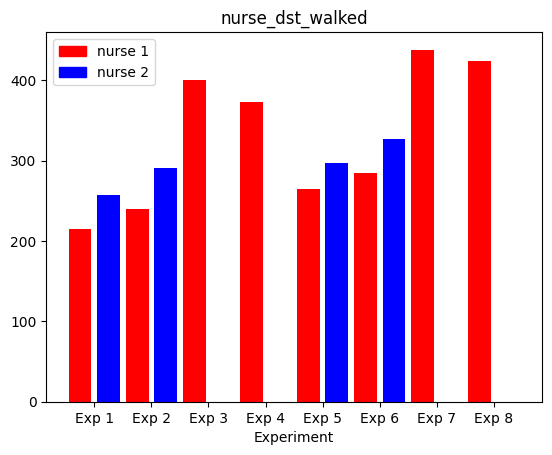

['Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 'Exp 5', 'Exp 6', 'Exp 7', 'Exp 8']
[np.float64(215.30132493849555), np.float64(257.2038095596357), np.float64(239.8437416255832), np.float64(290.3467256336251), np.float64(400.0807008549533), 0.0, np.float64(373.3568480954528), 0.0, np.float64(264.3221608314733), np.float64(296.6038095596357), np.float64(285.23906664860607), np.float64(327.38926678947246), np.float64(438.12678229483447), 0.0, np.float64(424.6153255959807), 0.0]


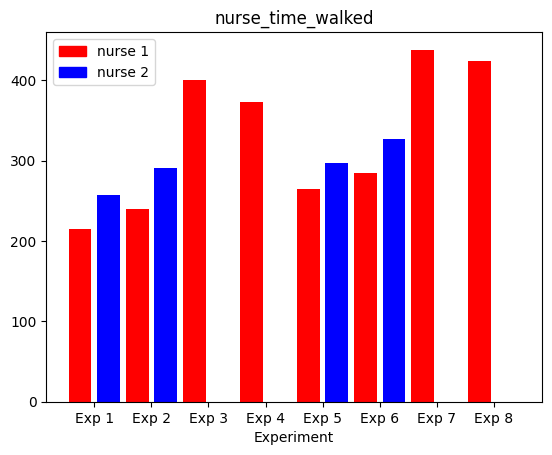

['Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 'Exp 5', 'Exp 6', 'Exp 7', 'Exp 8']
[np.float64(1224.1270257764472), np.float64(1179.3251005363556), np.float64(1053.7833921677807), np.float64(1051.8674947935713), np.float64(2403.4521263128026), 0.0, np.float64(2403.4521263128026), 0.0, np.float64(1224.1270257764472), np.float64(1179.3251005363556), np.float64(1088.8700766710303), np.float64(1078.0055436554171), np.float64(2403.4521263128026), 0.0, np.float64(2403.4521263128026), 0.0]


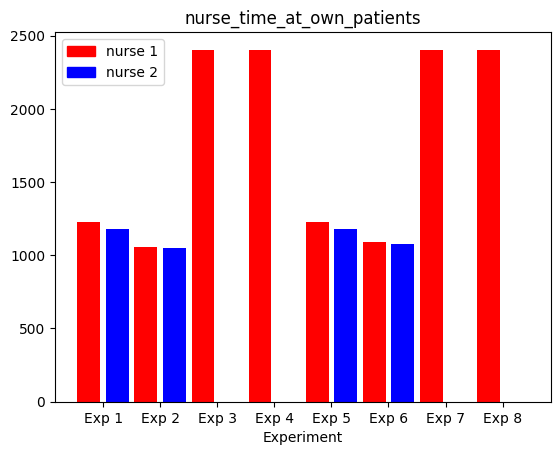

['Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 'Exp 5', 'Exp 6', 'Exp 7', 'Exp 8']
[0.0, 0.0, np.float64(127.45760574278407), np.float64(170.34363360866678), 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, np.float64(101.31955688093805), np.float64(135.25694910541702), 0.0, 0.0, 0.0, 0.0]


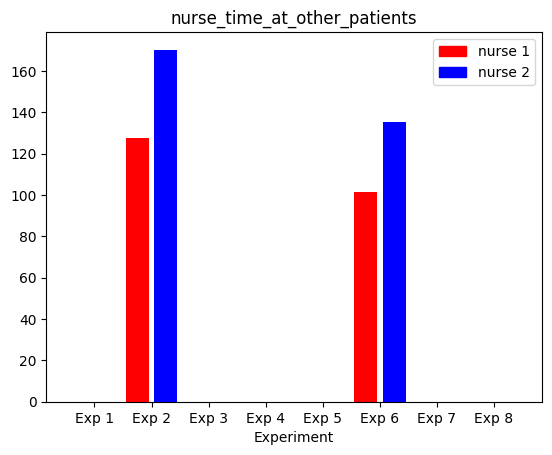

['Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 'Exp 5', 'Exp 6', 'Exp 7', 'Exp 8']
[np.float64(2016.4248576207253), np.float64(2019.3242982396773), np.float64(2034.76846879952), np.float64(1943.2953542998046), np.float64(762.3219076056533), 0.0, np.float64(770.4841217246218), 0.0, np.float64(1967.4040217277477), np.float64(1979.9242982396772), np.float64(1980.4245081350934), np.float64(1915.2014487853608), np.float64(724.2758261657724), 0.0, np.float64(719.1906147840151), 0.0]


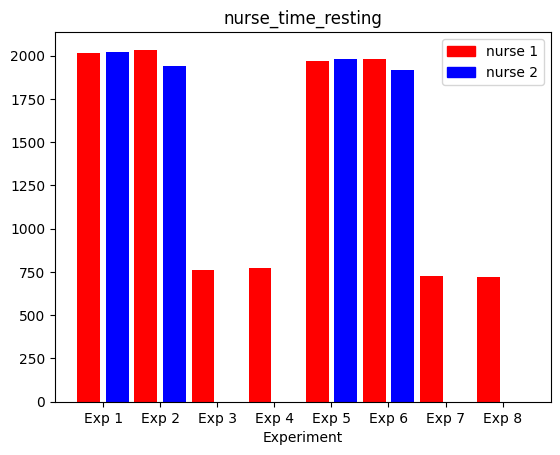

In [18]:
def plot_nurse_stat(stat_name):
    values = [0 for _ in range(len(nurse_results) * 2 )] # amounts to be plotted in bar chart
    runs = len(nurse_results[0])
    for i, exp in enumerate(nurse_results):
        for run in exp:
            values[i * 2] += run[0][stat_name]
            # values.append(run[0][stat_name])
            if len(run) == 2: # there are two nurses, so update the second bar of that experiment
                # values.append(run[1][stat_name])
                values[i * 2 + 1] += run[1][stat_name]
            # else:
                # values.append(0)

    # values has the sum of all results, average them
    values = list(map(lambda x: x / runs, values)) 

    labels = ["Exp " + str(x + 1) for x in range(8)] # experiment scenario names
    colors = ['red' if i % 2 == 0 else 'blue' for i in range(len(values))] #alternating colors for nurses
    print(labels)
    print(values)
    x = np.arange(len(values))

    # plot the actual bars
    plt.bar(x, values, color=colors)

    # write labels under each pair of values
    plt.xticks(ticks=np.arange(0.5, len(values), 2), labels=labels)

    # red_patch = plt.Line2D([0], [0], color='red', lw=4, label='nurse 1')
    # blue_patch = plt.Line2D([0], [0], color='blue', lw=4, label='nurse 2')
    # create legend
    red_patch = mpatches.Circle((0, 0), radius=0.1, color='red', label='nurse 1')
    blue_patch = mpatches.Circle((0, 0), radius=0.1, color='blue', label='nurse 2')
    plt.legend(handles=[red_patch, blue_patch])

    # titles
    plt.xlabel("Experiment")
    plt.ylabel("")
    plt.title(stat_name)

    plt.show()

nurse_stats = nurse_results[0][0][0].keys()
for stat in nurse_stats:
    plot_nurse_stat(stat)

## Test prints

In [ ]:
df = pd.read_csv(project_root + "/output/testNurseLog.csv")
df

In [ ]:
time_rows = df[(df['nurse'] == 0) & (df['patient'] == 0) & (df['action'] == "time at patient")].event.tolist()
time_rows


In [ ]:
df115 = df[df['event'] == 82].reset_index(drop=True)
df115

In [ ]:
# Find the index of the row where action is 'time at patient'
time_at_patient_idx = df115[df115['action'] == 'time at patient'].index[0]
print(time_at_patient_idx)

total_time = 0
int_end_time = df115.loc[time_at_patient_idx].time #end of current calculated interval
# Iterate backward from this index to find the first occurrence of 'move to'
for idx in range(time_at_patient_idx, -1, -1):
    line = df115.loc[idx]
    action = line["action"]
    if action == 'move to' or idx == 0:
        total_time += int_end_time - line["time"]
        break
    if action == 'assign event':
        total_time += int_end_time - line["time"]
    elif action == 'unassign event':
        int_end_time = line["time"]
    print(idx, action, total_time)

print(total_time)

In [ ]:
df115.iloc[-1]

In [ ]:
req_levels = [2, 3]
level_probabilities = [0.75, 0.25]
level = np.random.choice(req_levels, p=level_probabilities)
req = {}
req["level"] = level

print(req["level"])

In [ ]:
val = np.int64(2)
print(type(int(val)))